Generate XRD composition "scans" by interpolating between different CoxNix phases. We put in exaggerated (i.e. unphysical) lattice parameter changes to test the peak shift invariance of embedding models.

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [49]:
CoNi = pd.read_json("../xrdc/inputs/mp-1226076_xrd_Cu_CoNi.json", lines=True)
Co = pd.read_json("../xrdc/inputs/mp-1183710_xrd_Cu_Co.json", lines=True)
Ni = pd.read_json("../xrdc/inputs/mp-10257_xrd_Cu_Ni.json", lines=True)
Sn = pd.read_json("../xrdc/inputs/mp-117_xrd_Cu_Sn.json", lines = True)

# FCC nickel is actually the main phase, but for modeling sake we'll keep the above
#Ni = pd.read_json("../xrdc/inputs/mp-23_xrd_Cu_Ni_fcc.json", lines = True)

In [50]:
# from xrdc.xrdutils import *
from xrdc import xrdutils as xdu

In [51]:
import pdb

In [52]:
def from_json(df):
    patterns = np.array(df.pattern.iloc[0], dtype = object)
    intensities, angles = patterns[:, 0].astype(float), patterns[:, 2].astype(float)
    q = xdu.to_q(angles)
    return q, intensities

def df_to_pat(df):
    q, i = from_json(df)
    pat = xdu.mk_pattern(i, q, .01)
    return q, i, pat

def plt_pat(df, **kwargs):
    q, i, pat = df_to_pat(df)
    plt.plot(xdu.q_grid, pat, **kwargs)
    return xdu.q_grid, pat, i, q\

# moved to xrdutils.py
# def agg(X, n_classes = 25):
#     #assert n_classes * per_class == X.shape[0]
#     CoNi_members = X.reshape(n_classes, X.shape[0] // n_classes, X.shape[1]).sum(axis = 1)
#     CoNi_y = np.hstack([np.repeat(i, 1) for i in range(n_classes)])[None, :].T
#     #pdb.set_trace()
#     return CoNi_members, CoNi_y

# moved to simulation.py
# def sample_transition(X, n_classes = 24, per_class = 500, **kwargs):
#     #X = np.vstack(pieces)
#     X, _ = agg(X, n_classes = n_classes)
#     X_samples, y, _ = xdu.mk_simdata(X, per_class, -.5, .5, xdu.q_grid, scale_type = 'shift', **kwargs)
#     return X_samples, y

def group_patterns(*pieces, n_classes = 200, rmin = -.2, rmax = .2):
    """
    Instead of averaging the rows and doing data augmentation, just group them.
    """
    per_class = 600 // n_classes
    X = np.vstack(pieces)
    y = np.hstack([np.repeat(i, per_class) for i in range(n_classes)])[None, :].T
    X = np.vstack([condense(mutate_pattern(row, np.random.uniform(rmin, rmax), scale_type = 'shift', peak_height = True), 150) for row in X])
    return X, y

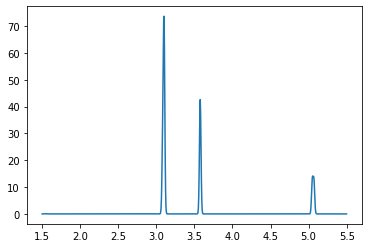

In [53]:
_, _, ib, qb = plt_pat(CoNi);

In [39]:
qb.shape

(31,)

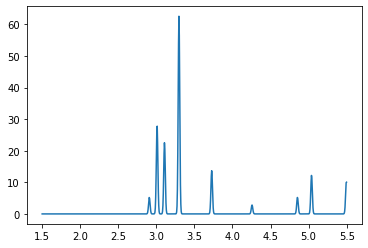

In [40]:
qqa, iia, ia, qa = plt_pat(Co);

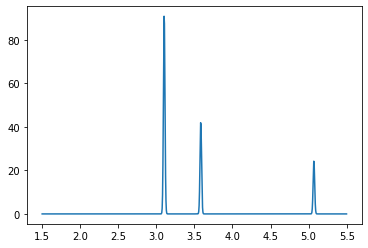

In [41]:
qqc, iic, ic, qc = plt_pat(Ni);

In [42]:
# _, _, ie, qe = plt_pat(Ni_fcc);

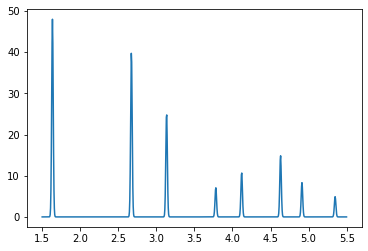

In [43]:
_, _, id, qd = plt_pat(Sn);

In [44]:
%matplotlib inline

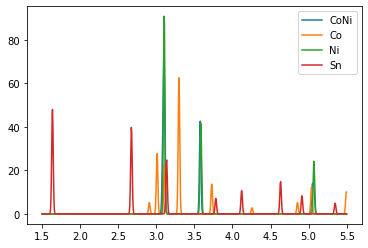

In [48]:
plt_pat(CoNi, label = 'CoNi');
plt_pat(Co, label = 'Co');
plt_pat(Ni, label = 'Ni');
plt_pat(Sn, label = 'Sn');
plt.legend()

In [46]:
# moved to simulation.py
# def transition(start_scale, end_scale, start_pair, end_pair, N, sigma = .01, scale_type = 'scale'):
#     """
#     pair -> [qs, intensities]
    
#     scale_type == 'scale' changes peak positions multiplicatively (in q)
#     scale_type == 'shift' shifts peak positions equally (which is not what a lattice parameter change does,
#         but it's simpler than doing the q -> log(q) substitution and pretty much equivalent for model testing
#         purposes)
        
#     TODO
#     Lorentz factor
#     peak height variation
#     """
#     scales = np.linspace(start_scale, end_scale, N)
#     res = []
#     q0, i0 = start_pair
#     q1, i1 = end_pair
    
#     qq, ii = np.hstack((q0, q1)), np.hstack((i0, i1))
#     span = np.abs(start_scale - end_scale)
#     for i, s in enumerate(scales):
#         if scale_type == 'scale':
#             q, i = qq * s, np.hstack((i0 * (N - i) / N, i1 * i / N)) #todo off by one
#         elif scale_type == 'shift':
#             q, i = qq + s, np.hstack((i0 * (N - i) / N, i1 * i / N)) #todo off by one
#         else:
#             raise Exception 
#         pat = xdu.mk_pattern(i, q, sigma)
#         res.append(pat)
#     return np.vstack(res)


In [14]:
qt, it = np.array([1, 2]), np.array([.5, .6])
qt2, it2 = np.array([2, 3]), np.array([.4, .2])

assert transition(1, 1.5, (qt, it), (qt2, it2), 2).shape == (2, q_grid.shape[0])

NameError: name 'q_grid' is not defined

2D scan of 1D XRD patterns, henceforth known as "the dataset":

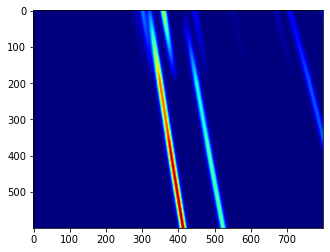

In [47]:
sigma = .03
Co_to_CoNi = transition(1, 1.05, (qa, ia), (qb, ib), 200, sigma)

CoNi_to_CoNi = transition(1.05, 1.1, (qb, ib), (qb, ib), 200, sigma)

CoNi_to_Ni = transition(1.1, 1.15, (qb, ib), (qc, ic), 200, sigma)

X = np.vstack((Co_to_CoNi, CoNi_to_CoNi, CoNi_to_Ni))
plt.imshow(X, cmap = 'jet')

## NMF decomposition

In [30]:
from sklearn.decomposition import NMF

In [31]:
def do_nmf(n = 10):
    model = NMF(n_components=n, init='random', random_state=0, max_iter = 1000)
    W = model.fit_transform(X.T)
    H = model.components_
    return W, H, np.linalg.norm(np.dot(W, H) - X.T)

In [32]:
nn = np.arange(1, 41, dtype = int)

losses = np.array([do_nmf(n)[2] for n in nn])

/Users/ollie/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/Users/ollie/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/Users/ollie/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/Users/ollie/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/Users/ollie/anaconda3/l

In [279]:
%matplotlib inline

Text(0, 0.5, 'L2 loss')

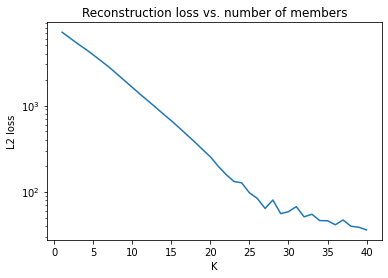

In [35]:
plt.plot(nn, losses)
plt.semilogy()
plt.title("Reconstruction loss vs. number of members")
plt.xlabel("K")
plt.ylabel("L2 loss")

In [16]:
K = 10
W, H, loss = do_nmf(K)
loss

NameError: name 'do_nmf' is not defined

In [17]:
%matplotlib inline
plt.imshow(np.hstack((X.T, (np.dot(W, H)))), cmap = 'jet')
plt.title("Original and reconstructed (K = {})".format(K))

NameError: name 'W' is not defined

In [319]:
%matplotlib notebook

In [16]:
import tensorflow as tf
from importlib import reload
from xrdc import utils

reload(utils)

<module 'xrdc.utils' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/utils/__init__.py'>

In [572]:
# from tensorflow.keras.datasets import mnist

# a, b = mnist.load_data()

In [39]:
# def to_img(y_cond, size, v_padding = 2):
#     normed = y_cond / y_cond.max()
#     y_indices = (v_padding - 1 + (size - 2 * v_padding) * normed).astype(int)
#     sig2d = np.zeros((size, size))
#     x_indices = np.arange(0, size, step = 1)
#     sig2d[x_indices, y_indices] = 1
#     return sig2d.T[::-1]

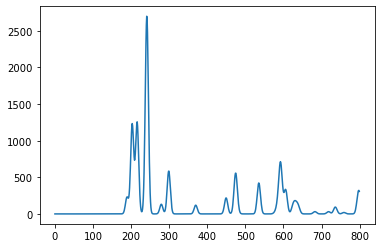

In [265]:
plt.plot(CoNi_members[0])

In [266]:
reload(utils)

<module 'xrdc.utils' from '/Users/ollie/Documents/SLAC/xrdsim/xrdc/utils.py'>

In [15]:
CoNi_members, CoNi_y = agg(X)

CoNi_x, CoNi_y = sims.mk_simdata(CoNi_members, 500, 20, scale_type = 'scale')

NameError: name 'sims' is not defined

In [268]:
CoNi_test_x, CoNi_test_y = np.repeat(CoNi_test_x, 7, axis = 0)[:10000, :], np.repeat(CoNi_test_y, 7, axis = 0)[:10000]

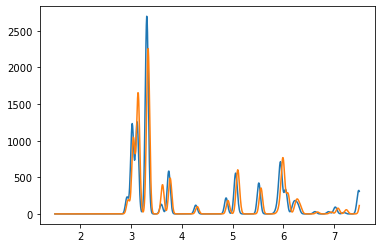

In [237]:
plt.plot(q_grid, CoNi_members[0])
plt.plot(q_grid, CoNi_members[1])

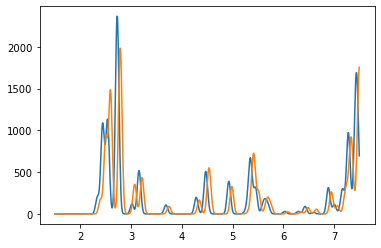

In [239]:
plt.plot(q_grid, CoNi_members_shift[0])
plt.plot(q_grid, CoNi_members_shift[1])

In [195]:
utils.write_train_test("data/CoNi_3/", CoNi_x, CoNi_y, CoNi_x, CoNi_y)

In [199]:
# Co_to_CoNi_shift = transition(-.6, -.2, (qa, ia), (qb, ib), 200, sigma, scale_type = 'shift')

# CoNi_to_CoNi_shift = transition(-.2, .2, (qb, ib), (qb, ib), 200, sigma, scale_type = 'shift')

# CoNi_to_Ni_shift = transition(.2, .6, (qb, ib), (qc, ic), 200, sigma, scale_type = 'shift')

More realistic dataset (lattice parameter changes only in multi phase region):

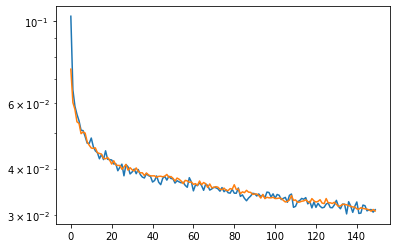

In [190]:
import matplotlib.pyplot as plt
plt.semilogy()
plt.plot(stats_collector['train_loss'])
plt.plot(stats_collector['val_loss'])

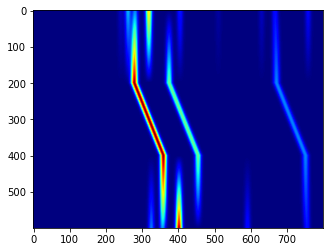

In [18]:
sigma = .03
shift_size = .2
Co_to_CoNi_shift = transition(-shift_size, -shift_size, (qa, ia), (qb, ib), 200, sigma, scale_type = 'shift')

CoNi_to_CoNi_shift = transition(-shift_size, shift_size, (qb, ib), (qb, ib), 200, sigma, scale_type = 'shift')

CoNi_to_Ni_shift = transition(shift_size, shift_size, (qb, ib), (qc, ic), 200, sigma, scale_type = 'shift')

X = np.vstack((Co_to_CoNi_shift, CoNi_to_CoNi_shift, CoNi_to_Ni_shift))
plt.imshow(X, cmap = 'jet')

In [284]:
CoNi_x_shift, CoNi_y_shift = sample_transition(np.vstack((Co_to_CoNi_shift, CoNi_to_CoNi_shift, CoNi_to_Ni_shift)), n_classes = 24, per_class = 200)

xdu.write_train_test("data/CoNi_shift_2/", CoNi_x_shift, CoNi_y_shift, CoNi_x_shift, CoNi_y_shift // 8)

scale type: shift
q jitter: None
peak height variation True


In [20]:
rm -r ./tmp/siamese-constrastive_1d-XRD-CoNi_shift_2_0-gif

In [55]:
%run ../../siamese-net-and-friends/train.py siamese-constrastive_1d XRD --train_path data/CoNi_shift_2/train/ --test_path data/CoNi_shift_2/test/\
    --name CoNi_shift_2_1 \
    --n_classes 177 --epochs 200

  0%|          | 0/30000 [00:00<?, ?it/s, epoch=0, train_loss=0, val_loss=-1]

4
./data/XRD


100%|██████████| 30000/30000 [06:34<00:00, 75.98it/s, epoch=199, train_loss=0.0317, val_loss=0.0293] 


Saving artifacts to ./tmp/siamese-constrastive_1d-XRD-CoNi_shift_2_1-*


<Figure size 432x288 with 0 Axes>

## Co-Ni toy system: siamese network latent space distribution

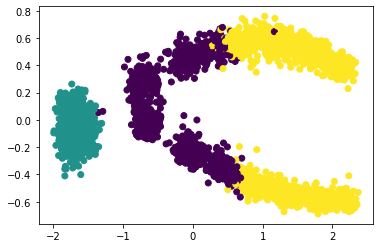

In [57]:
X = utils.get_embedding(net, original_test_loader)[0]

Xpca, ypred = xdu.gcluster(X, N = 3)
plt.scatter(*(Xpca.T), c = ypred)

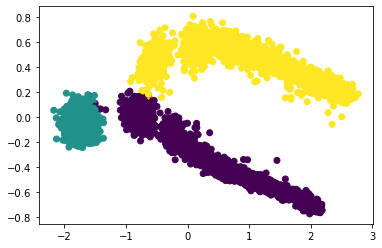

In [213]:
X = utils.get_embedding(net, original_test_loader)[0]

Xpca, ypred = gcluster(X, N = 3)
plt.scatter(*(Xpca.T), c = ypred)

In [220]:
CoNi_y_shift.shape

(1000, 1)

### Add a fourth transition from Ni to Co to complete the loop:

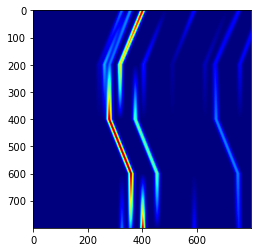

In [19]:
sigma = .03
Ni_to_Co = transition(shift_size, -shift_size, (qc, ic), (qa, ia), 200, sigma, scale_type = 'shift')

X = np.vstack((Ni_to_Co, Co_to_CoNi_shift, CoNi_to_CoNi_shift, CoNi_to_Ni_shift))
plt.imshow(X, cmap = 'jet')

In [25]:
CoNi_x_shift, CoNi_y_shift = sample_transition(Co_to_CoNi_shift, CoNi_to_CoNi_shift, CoNi_to_Ni_shift, n_classes = 200, per_class = 5)

TypeError: sample_transition() got multiple values for argument 'n_classes'

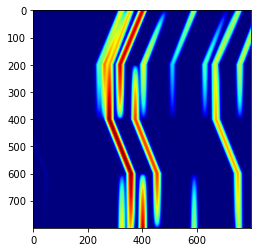

In [219]:
plt.imshow(np.log(1 + X), cmap = 'jet')

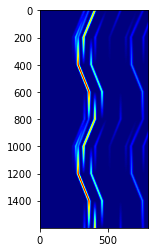

In [218]:
plt.imshow(np.vstack((X, X)), cmap = 'jet')

In [269]:
CoNi_x_shift_extended, CoNi_y_shift_extended = sample_transition(Ni_to_Co, Co_to_CoNi_shift, CoNi_to_CoNi_shift, CoNi_to_Ni_shift, n_classes = 40, per_class = 250)

scale type: shift
q jitter: None


In [284]:
write_train_test("data/CoNi_shift_extended/", CoNi_x_shift_extended, CoNi_y_shift_extended,
                 CoNi_x_shift_extended, CoNi_y_shift_extended // 10)

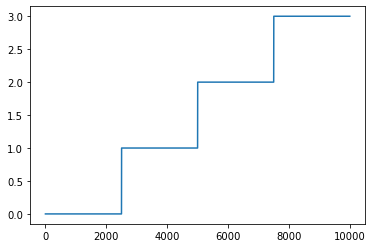

In [285]:
plt.plot(CoNi_y_shift_extended // 10)

In [286]:
prefix="CoNi_shift_extended"
%run ../../siamese-net-and-friends/train.py siamese-constrastive_1d XRD --train_path data/$prefix/train/ --test_path data/$prefix/test/\
    --name $prefix \
    --n_classes 200 --epochs 150

  0%|          | 0/46950 [00:00<?, ?it/s, epoch=0, train_loss=0, val_loss=-1]

4
./data/XRD


100%|██████████| 46950/46950 [09:36<00:00, 81.42it/s, epoch=149, train_loss=0.026, val_loss=0.0255]  


Saving artifacts to ./tmp/siamese-constrastive_1d-XRD-CoNi_shift_extended-*


<Figure size 432x288 with 0 Axes>

## Add two more single-phase regions

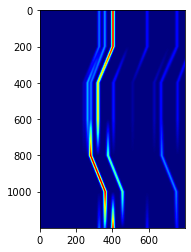

In [20]:
# todo spread out the peak shifting
sigma = .03
Ni_to_Co = transition(shift_size, -shift_size, (qc, ic), (qa, ia), 200, sigma, scale_type = 'shift')
Ni = transition(shift_size, shift_size, (qc, ic), (qc, ic), 200, sigma, scale_type = 'shift')
Co = transition(-shift_size, -shift_size, (qa, ia), (qa, ia), 200, sigma, scale_type = 'shift')

X = np.vstack((Ni, Ni_to_Co, Co, Co_to_CoNi_shift, CoNi_to_CoNi_shift, CoNi_to_Ni_shift))
plt.imshow(X, cmap = 'jet')

In [20]:
Ni[0].mean()

1.0

In [400]:
CoNi_x_shift_extended_2, CoNi_y_shift_extended_2 = sample_transition(Ni, Ni_to_Co, Co, Co_to_CoNi_shift, CoNi_to_CoNi_shift, CoNi_to_Ni_shift, n_classes = 60, per_class = 200)

scale type: shift
q jitter: None


In [405]:
(CoNi_y_shift_extended_2 // 20).mean()

1.0

In [413]:
write_train_test("data/CoNi_shift_extended_2/", CoNi_x_shift_extended_2, CoNi_y_shift_extended_2,
                 CoNi_x_shift_extended_2, CoNi_y_shift_extended_2 // 10)

4
./data/XRD


100%|██████████| 112500/112500 [24:54<00:00, 75.25it/s, epoch=299, train_loss=0.026, val_loss=0.0237]  


Saving artifacts to ./tmp/siamese-constrastive_1d-XRD-CoNi_shift_extended_2-*


<IPython.core.display.Javascript object>


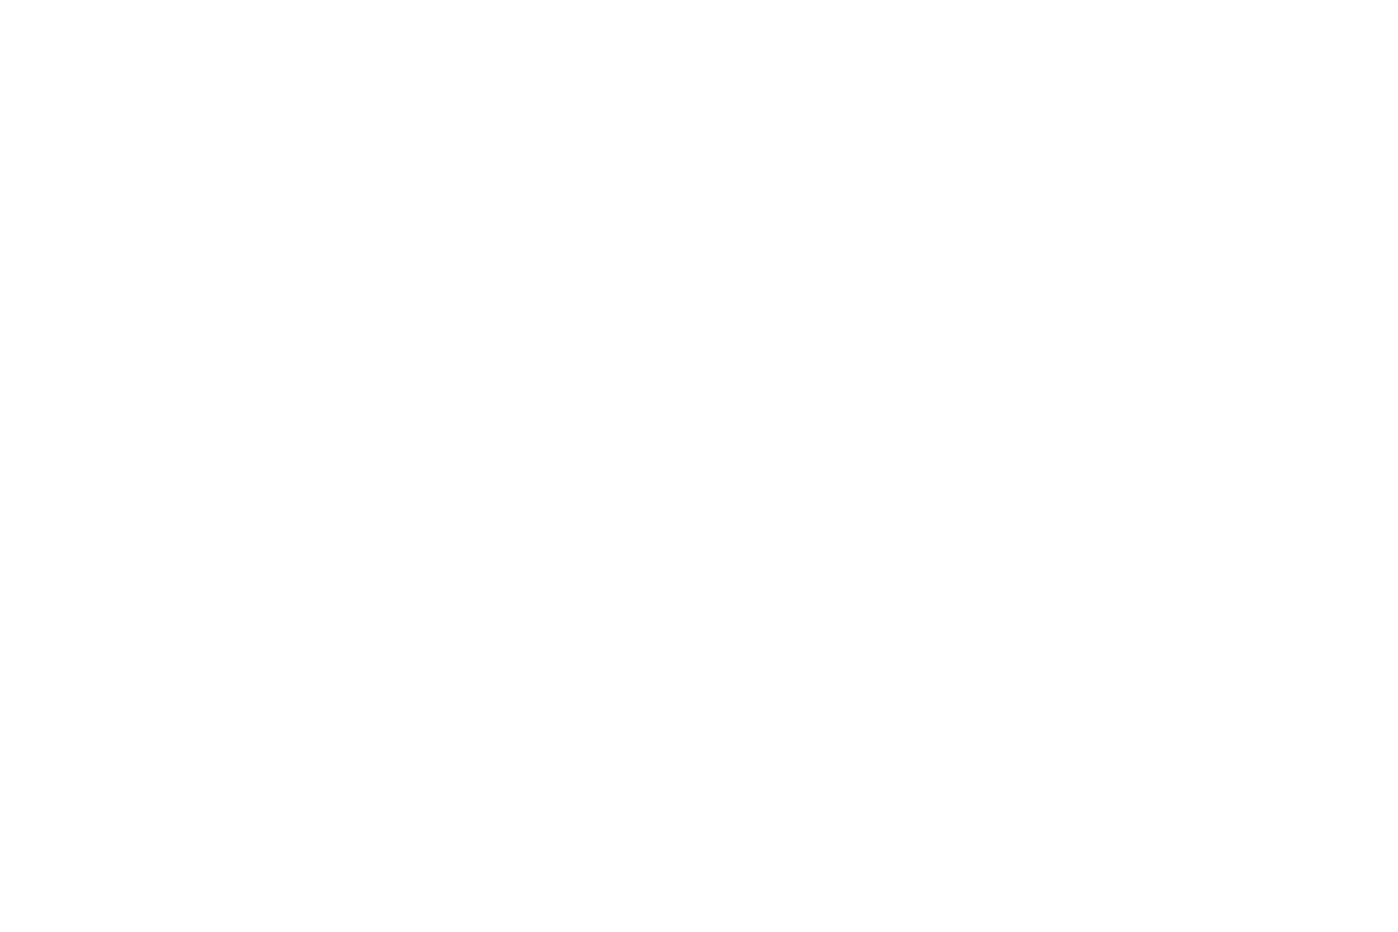

In [416]:
prefix="CoNi_shift_extended_2"
%run ../../siamese-net-and-friends/train.py siamese-constrastive_1d XRD --train_path data/$prefix/train/ --test_path data/$prefix/test/\
    --name $prefix \
    --n_classes 60 --epochs 300

### GMM-assigned labels:

<IPython.core.display.Javascript object>


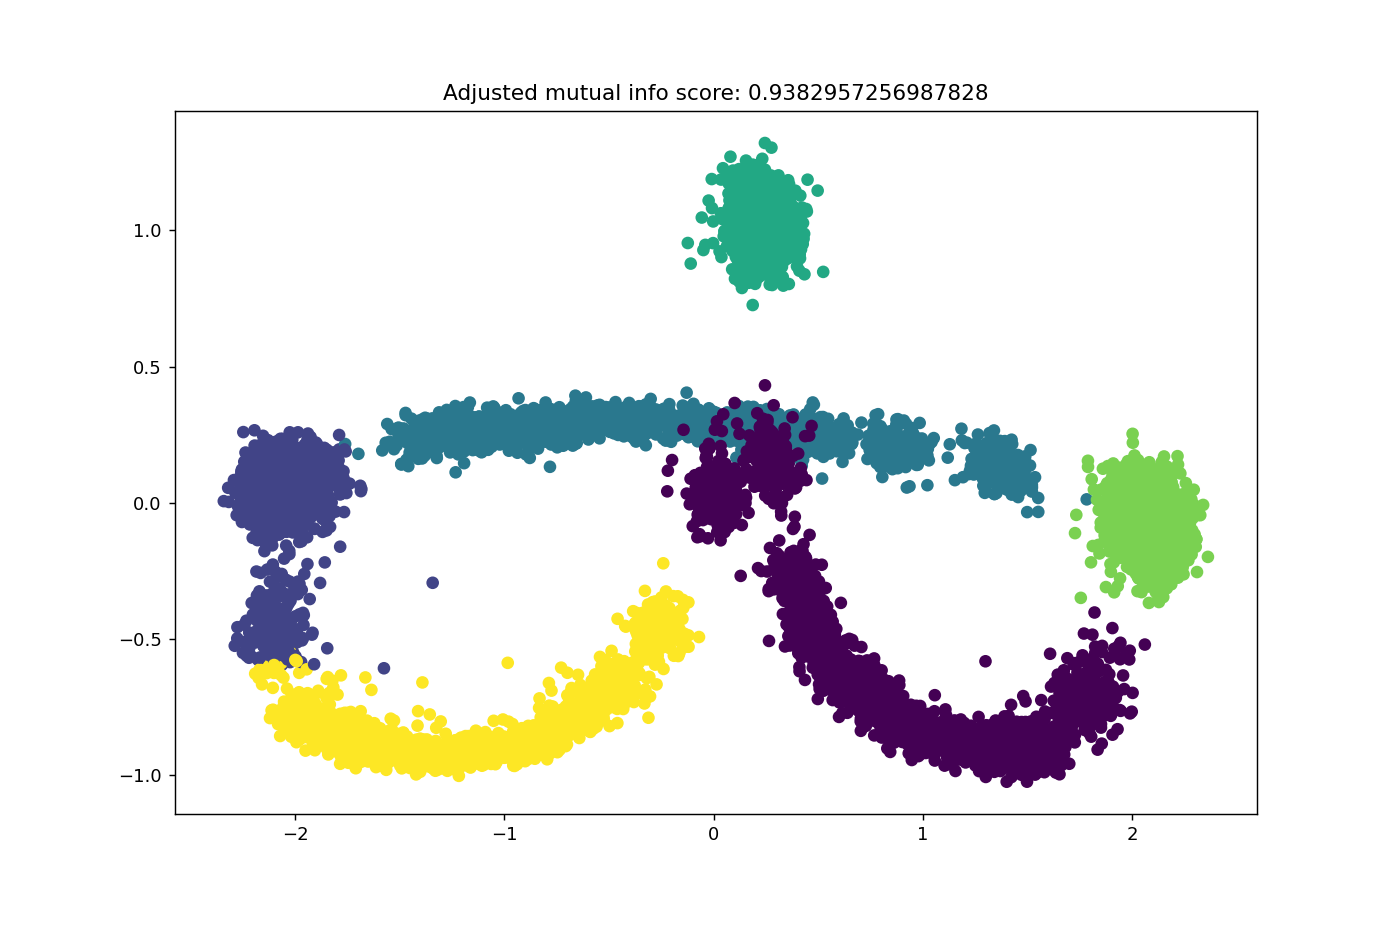

Text(0.5, 1.0, 'Adjusted mutual info score: 0.9382957256987828')

In [419]:
X_emb, y = utils.get_embedding(net, original_test_loader)

Xpca, ypred = gcluster(X_emb, N = 6)
plt.scatter(*(Xpca.T), c = ypred)
plt.title("Adjusted mutual info score: {}".format(adjusted_mutual_info_score(y, ypred)))

### True labels:

<IPython.core.display.Javascript object>


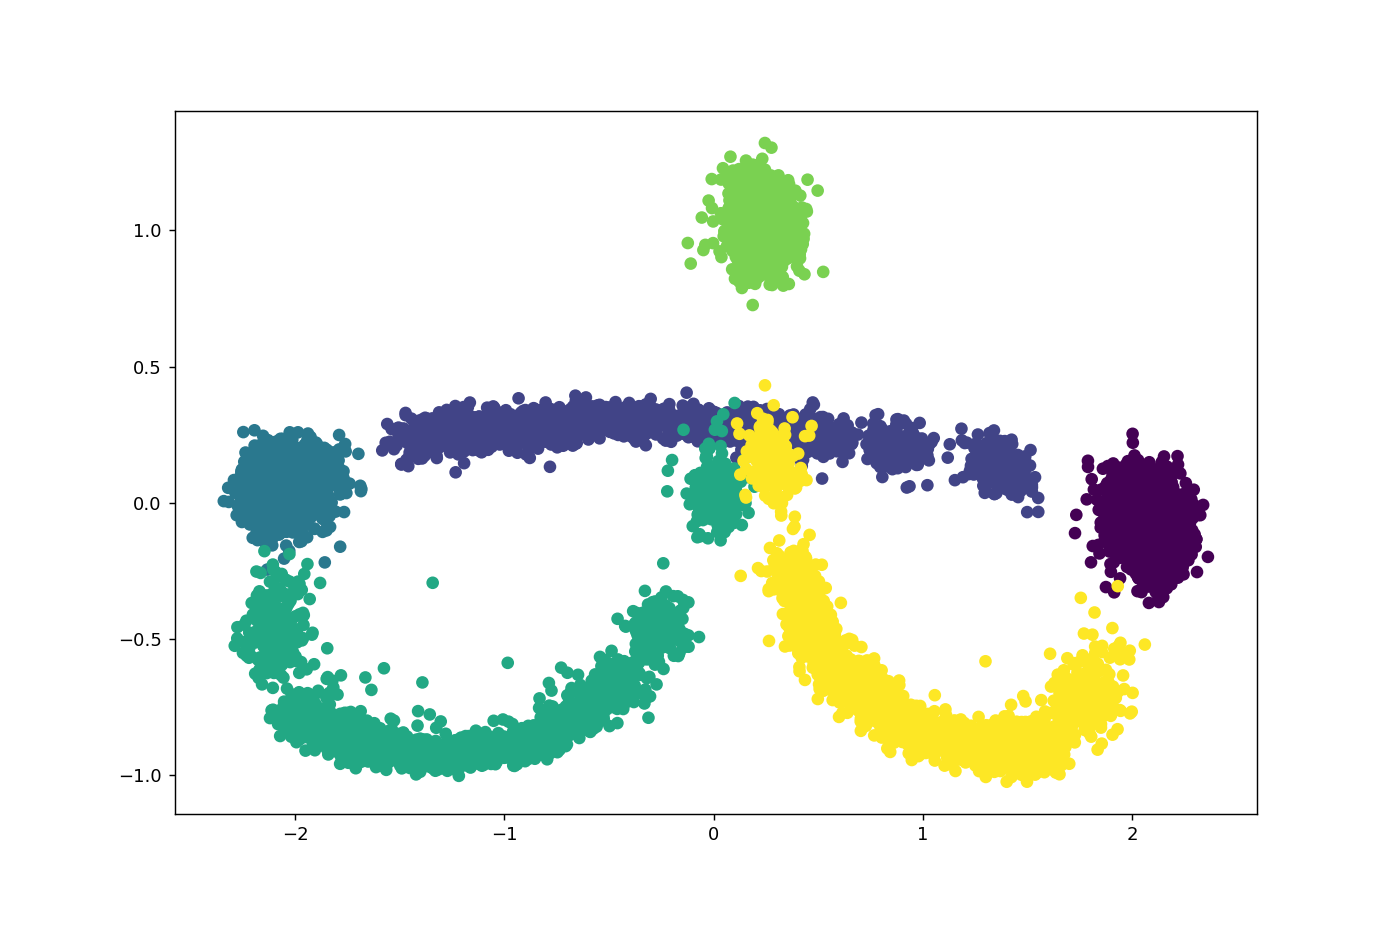

In [422]:
plt.scatter(*(Xpca.T), c = y)

## Add a fourth phase, Sn:

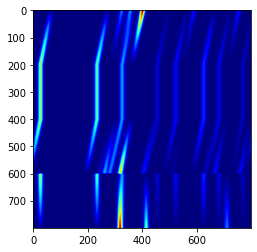

In [21]:
Ni_to_Sn = transition(shift_size, 0, (qc, ic), (qd, id), 200, sigma, scale_type = 'shift')
Sn_to_Co = transition(0, -shift_size, (qd, id), (qa, ia), 200, sigma, scale_type = 'shift')
Sn_to_CoNi = transition(0, 0, (qd, id), (qb, ib), 200, sigma, scale_type = 'shift')
Sn_to_Sn = transition(0, 0, (qd, id), (qd, id), 200, sigma, scale_type = 'shift')

X_Sn = np.vstack((Ni_to_Sn, Sn_to_Sn, Sn_to_Co, Sn_to_CoNi))
plt.imshow(X_Sn, cmap = 'jet')

In [437]:
CoNiSn_x_shift, CoNiSn_y_shift = sample_transition(np.vstack((X, X_Sn)), n_classes = 100, per_class = 150)

scale type: shift
q jitter: None


In [439]:
prefix="CoNiSn_shift"
write_train_test("data/{}/".format(prefix), CoNiSn_x_shift, CoNiSn_y_shift,
                 CoNiSn_x_shift, CoNiSn_y_shift // 10)
%run ../../siamese-net-and-friends/train.py siamese-constrastive_1d XRD --train_path data/$prefix/train/ --test_path data/$prefix/test/\
    --name $prefix \
    --n_classes 100 --epochs 300

4
./data/XRD


100%|██████████| 140700/140700 [29:05<00:00, 80.61it/s, epoch=299, train_loss=0.0161, val_loss=0.0156] 


Saving artifacts to ./tmp/siamese-constrastive_1d-XRD-CoNiSn_shift-*


<Figure size 432x288 with 0 Axes>

In [63]:
def embedding_gmm(N):
    X_emb, y = utils.get_embedding(net, original_test_loader)

    Xpca, ypred = gcluster(X_emb, N = N)
    plt.scatter(*(Xpca.T), c = ypred)
    plt.title("Adjusted mutual info score: {}".format(adjusted_mutual_info_score(y, ypred)))
    return Xpca, y, ypred

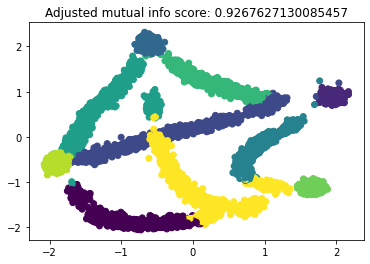

In [443]:
Xpca_tetra, y_tetra, ypred_tetra = embedding_gmm(10)

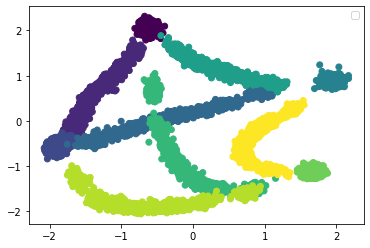

In [445]:
plt.scatter(*(Xpca_tetra.T), c = y_tetra)
plt.legend()

In [26]:
!pip install k-means-constrained

     |████████████████████████████████| 424 kB 5.1 MB/s eta 0:00:01
     |████████████████████████████████| 12.0 MB 6.6 MB/s eta 0:00:01


In [59]:
# N = 19
# gridx = gridy = gridz  = np.arange(N) / N

# xx, yy, zz = np.meshgrid(gridx, gridy, gridz)

# mask = (((xx + yy + zz) < 1.05) & ((xx + yy + zz) > .95))

# simplex_grid = np.vstack((xx[mask], yy[mask], zz[mask])).T
# simplex_grid = simplex_grid / np.sum(simplex_grid, axis = 1)[:, None]
# simplex_grid = simplex_grid[:200]
# print(simplex_grid.shape)

# Distribution to sample edges and corners more
def sample_1d(size = 1):
    rmax = 5
    yl = np.random.laplace(size = size)
    m1 = (yl < 0)
    yl[m1] = (rmax + yl[m1])
    #m2 = ((yl <= rmax) & (yl >= 0))
    yl = np.abs(yl) / rmax
    return yl

import ternary
from k_means_constrained import KMeansConstrained as KMC
def get_simplex_sample(N, mode = 'uniform', tol = .001, kmeans = True):
    """
    N: number of points to sampole
    mode: 'uniform' or 'biased'. 'biased' samples with highest marginal density at the edge of
        each dimension.
    """
    N0 = 3000000
    if mode == 'uniform':
        xx, yy, zz = np.random.uniform(size = N0), np.random.uniform(size = N0), np.random.uniform(size = N0)
    elif mode == 'biased':
        xx, yy, zz = sample_1d(N0), sample_1d(N0), sample_1d(N0)
    else:
        raise ValueError
    print(xx.mean())
    mask = (((xx + yy + zz) < 1. + tol) & ((xx + yy + zz) > 1. - tol))

    xx, yy, zz = xx[mask] / 1., yy[mask] / 1., zz[mask] / 1.

    simplex_sample = np.vstack((xx, yy, zz)).T
    simplex_sample = simplex_sample / np.sum(simplex_sample, axis = 1)[:, None]
    simplex_sample = simplex_sample[:N]

    
    if kmeans:
        kmeans = KMC(n_clusters=10, size_min = 20).fit(simplex_sample)
        fig, tax = ternary.figure()

        for i in range(10):
            tax.scatter(simplex_sample[kmeans.labels_ == i], marker='s', s = 2)

        simplex_sample = simplex_sample[np.argsort(kmeans.labels_)]
    print(simplex_sample.shape)
    return simplex_sample

0.5018797603349412
(200, 3)


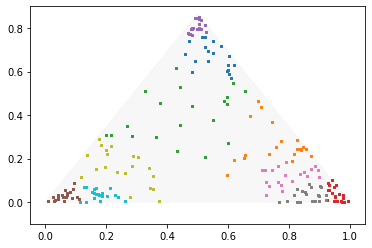

In [22]:
get_simplex_sample(200, 'biased');

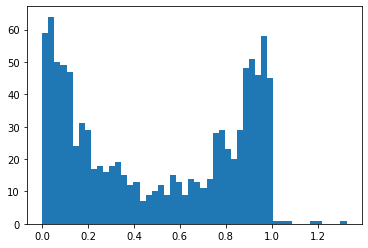

In [30]:
plt.hist(sample_1d(1000), bins = 50);

## Fill in faces:

In [23]:
def three_part_mix(weights, bases):
    a, b, c = bases
    return np.outer(weights[:, 0], a) + np.outer(weights[:, 1], b) + np.outer(weights[:, 2], c)

In [203]:
xtest, ytest = np.load('data/' + prefix + '/test/x.npy'), np.load('data/' + prefix + '/test/y.npy')

In [227]:
def get_threepoint_x():
    #xtrain, ytrain = np.load('data/' + prefix + '/test/x.npy')
    Xtest, ytest = np.load('data/' + prefix + '/test/x.npy'), np.load('data/' + prefix + '/test/y.npy')
    #Xtest, ytest = utils.get_embedding(net, original_test_loader)
    m1 = (ytest == threepoints_idx[0]).T[0]
    m2 = (ytest == threepoints_idx[1]).T[0]
    m3 = (ytest == threepoints_idx[2]).T[0]
    return (Xtest[m1], Xtest[m2], Xtest[m3]), (ytest[m1], ytest[m2], ytest[m3])

points = (Ni, Co, Sn_to_Sn, CoNi_to_CoNi_shift)
threepoints = (Ni, Co, CoNi_to_CoNi_shift)
threepoints_idx = [0, 1, 3]
edges = (Ni_to_Co, Co_to_CoNi_shift, CoNi_to_Ni_shift, Ni_to_Sn, Sn_to_Co, Sn_to_CoNi)

In [228]:
threepoints_augmented_x, threepoints_augmented_y = get_threepoint_x()

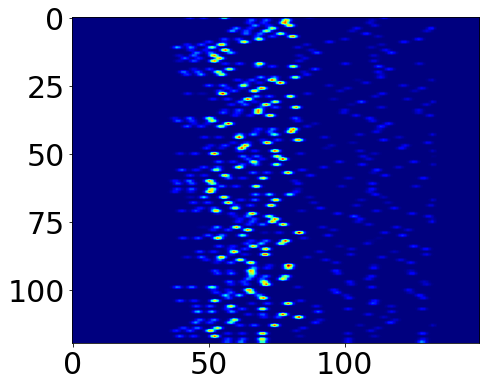

In [258]:
sample_x = np.vstack(threepoints_augmented_x)[::10][:120]
sample_y = np.vstack(threepoints_augmented_y)[::10][:120]
plt.imshow(sample_x, cmap = 'jet')

In [252]:
# Clustering based on embedding doesn't seem to help to organize the visualization much
# ld = ndarr_to_dataloader(sample_x, sample_y)

# sample_emb = utils.get_embedding(net, ld)[0];

# kmeans = KMC(n_clusters=15, size_min = 8).fit(sample_emb)
# isort = np.argsort(kmeans.labels_)

# sample_x = sample_x[isort]
# sample_y = sample_y[isort]
# plt.imshow(sample_x, cmap = 'jet', interpolation = None)

In [33]:
simplex_sample[:, 0].argmax(), simplex_sample[:, 1].argmax(), simplex_sample[:, 2].argmax()

(405, 180, 518)

In [36]:
# check normalization
assert (points[0][0].sum() / points[2][0].sum()) == 1

[0.51763396 0.09476515 0.38760089]


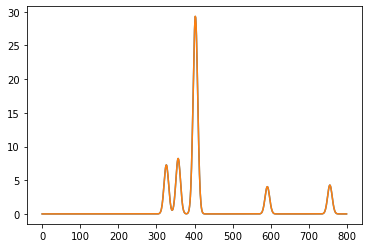

In [216]:
plt.plot(tm[884])
print(simplex_sample[0])
plt.plot(points[0][0])
# plt.plot(points[1][0])
# plt.plot(points[2][0])

In [34]:
from itertools import combinations

def get_faces(simplex_sample):
    # take the first row of each single-phase dataset
    faces = tuple([three_part_mix(simplex_sample, p) for p in combinations([arr2d[0] for arr2d in points], 3)])
    assert (faces[0].shape == points[0].shape)
    return faces

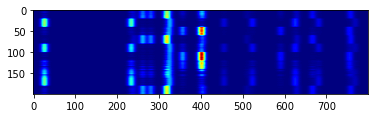

In [257]:
plt.imshow(faces[0], cmap = 'jet')

## 3-phase mixture with uniform sampling

In [44]:
three_part_mix(simplex_sample, [p[0] for p in threepoints]).shape

(200, 800)

In [350]:
from torch.utils.data import TensorDataset, DataLoader

def do_pca(X):
    from sklearn.decomposition import PCA

    pca = PCA(n_components=2)
    Xpca = pca.fit_transform(X)
    return pca, Xpca

def xrd_to_embedding(xface, yface):
    #tensor_x = torch.Tensor(CoNiSn_x_shift_faces[:, None, :]) # transform to torch tensor
    tensor_x = torch.Tensor(xface[:, None, :]) # transform to torch tensor

    #tensor_y = torch.Tensor(CoNiSn_y_shift_faces)
    tensor_y = torch.Tensor(yface[:, None])

    my_dataset = TensorDataset(tensor_x, tensor_y) # create your datset
    dataloader = DataLoader(my_dataset) # create your dataloader
    
    emb_faces, y_faces = utils.get_embedding(net, dataloader)
    pca, pca_faces = do_pca(emb_faces)
    return pca, pca_faces

def sample_single_face(resample = False, resample_N = None, mode = 'uniform'):
    if resample:
        simplex_sample = get_simplex_sample(resample_N, mode = mode, kmeans = False)
    tm = three_part_mix(simplex_sample, [p[0] for p in threepoints])
#     #xface, yface = standardize_input(np.vstack(faces), (np.arange(800) // 200))
#     #xface, yface = standardize_input(np.vstack(points + faces), (np.arange(1600) // 200))
#     #xface, yface = standardize_input(np.vstack(points ), (np.arange(800) // 200))

#     #xface, yface = standardize_input(np.vstack(threepoints ), (np.arange(600) // 200))
    concat = np.vstack(threepoints + (tm,) )
    #concat = np.vstack(threepoints_augmented + (tm,) )
    xface, yface = standardize_input(concat, (np.arange(600 + tm.shape[0]) // 200))
    pca, pca_faces = xrd_to_embedding(xface, yface)


    return simplex_sample, pca, pca_faces

In [222]:
# now under datasets.py
# def ndarr_to_dataloader(X, Y):
#     tensor_x = torch.Tensor(X[:, None, :]) # transform to torch tensor
#     tensor_y = torch.Tensor(Y[:, None])
#     my_dataset = TensorDataset(tensor_x, tensor_y) # create your datset
    
#     dataloader = DataLoader(my_dataset) # create your dataloader
#     return dataloader

0.4996077005284773
(200, 3)


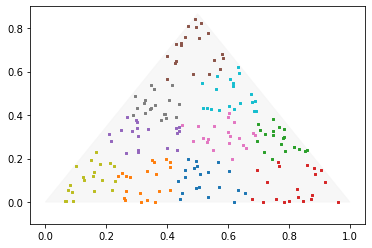

In [37]:
simplex_sample = get_simplex_sample(200, mode = 'uniform')
faces = get_faces(simplex_sample)

In [ ]:
CoNiSn_x_shift_faces, CoNiSn_y_shift_faces = sample_transition(np.vstack(points + edges + faces), n_classes = 140, per_class = 120)

In [150]:
args.train_path

'data/CoNiSn_shift_faces_500epoch_biased/train/'

In [149]:
add_prefix("train/x.npy")

'./tmp/siamese-constrastive_1d-XRD-CoNiSn_shift_faces_600epoch_uniform-train/x.npy'

In [147]:
CoNiSn_y_shift_faces // 10

array([[ 0],
       [ 0],
       [ 0],
       ...,
       [13],
       [13],
       [13]])

In [ ]:
CoNiSn_x_shift_faces.shape

In [102]:
prefix="CoNiSn_shift_faces_600epoch_uniform"
args.name = prefix

In [28]:
xdu.write_train_test("data/{}/".format(prefix), CoNiSn_x_shift_faces, CoNiSn_y_shift_faces,
                 CoNiSn_x_shift_faces, CoNiSn_y_shift_faces // 10)

In [30]:
%run ../../siamese-net-and-friends/train.py siamese-constrastive_1d XRD --train_path data/$prefix/train/ --test_path data/$prefix/test/\
    --name $prefix \
    --n_classes 140 --epochs 500

  0%|          | 0/262500 [00:00<?, ?it/s, epoch=0, train_loss=0, val_loss=-1]

4
./data/XRD


100%|██████████| 262500/262500 [57:48<00:00, 75.69it/s, epoch=499, train_loss=0.0105, val_loss=0.0113]  


Saving artifacts to ./tmp/siamese-constrastive_1d-XRD-CoNiSn_shift_faces_600epoch_uniform-*


<Figure size 432x288 with 0 Axes>

In [147]:
np.vstack(threepoints + (tm,)).shape

(1600, 800)

In [93]:
def setglobals(locald, names, values):
    for name, value in zip(names, values):
        locald[name] = value

net = torch.load(add_prefix('model.serialized'))
original_test_loader = torch.load(add_prefix('original_test_loader.serialized'))

0.49980147491762955
(200, 3)


[Text(1, 0, '0% Ni'), Text(1, 1, '100% Ni')]

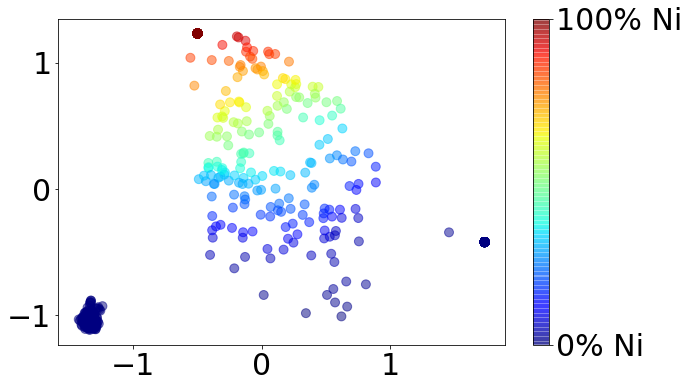

In [142]:
# N = 100
plt.rcParams['font.size'] = '30'
plt.rcParams["figure.figsize"]=(10, 6)

fig, ax = plt.subplots()
ss, _, pca_faces = sample_single_face(resample=True, resample_N=200, mode = 'uniform')
colors = np.hstack(((np.ones(200), np.zeros(400), ss[:, 0])))
cax = ax.scatter(*(pca_faces.T), c = (colors), cmap='jet', alpha = .5, s = 80)
cbar = fig.colorbar(cax, ticks=[0, 1])
cbar.ax.set_yticklabels(['0% Ni', '100% Ni'])

### Waterfall plot for patterns selected from the training data (just the phases plotted above)

In [263]:
tm = three_part_mix(simplex_sample, [p[0] for p in threepoints])
triangle_dataset = np.vstack(threepoints + (tm,))

Text(0.5, 0, 'q (1/Angstrom)')

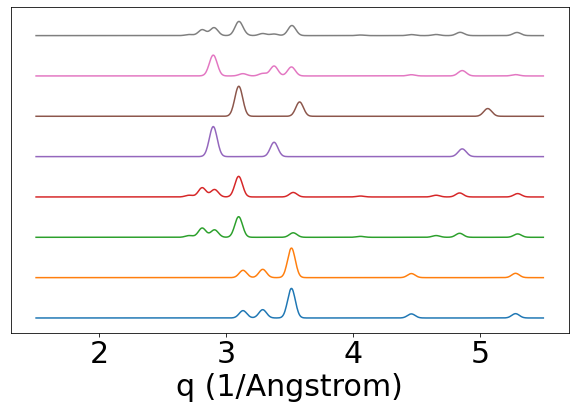

In [280]:
rows = triangle_dataset[::100]
ax1 = plt.axes()
ax1.axes.get_yaxis().set_visible(False)
for i, row in enumerate(rows):
    plt.plot(xdu.q_grid, row + i * 40)
plt.xlabel('q (1/Angstrom)')

Text(0.5, 0, 'q (1/Angstrom)')

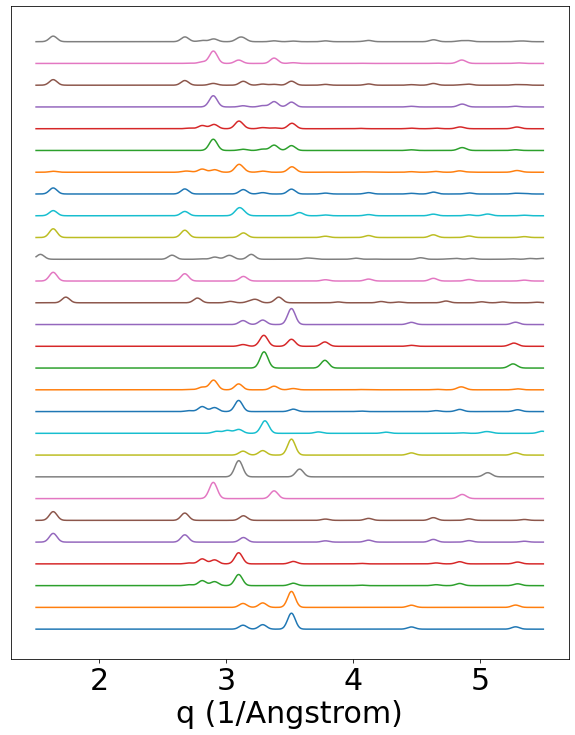

In [282]:
# Inc. Sn and two-and three-phase mixtures
plt.rcParams["figure.figsize"]=(10, 12)

rows = np.vstack(points + edges + faces)[::100]
ax1 = plt.axes()
ax1.axes.get_yaxis().set_visible(False)
for i, row in enumerate(rows):
    plt.plot(xdu.q_grid, row + i * 40)
plt.xlabel('q (1/Angstrom)')


In [171]:
threepoints[0].shape, threepoints_augmented[0].shape

((200, 800), (1200, 4))

0.5001213413955784
(200, 3)


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 4 and the array at index 3 has size 800

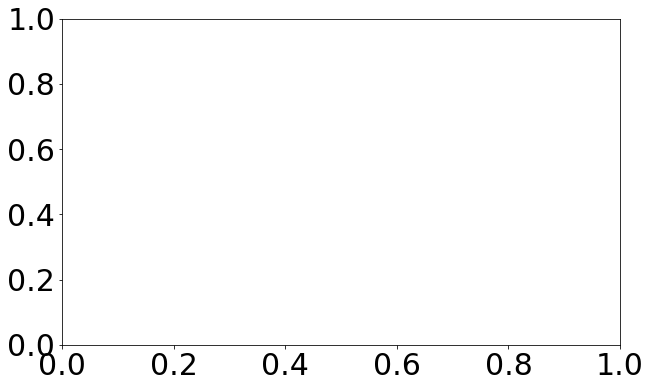

In [167]:
# N = 100
plt.rcParams['font.size'] = '30'

fig, ax = plt.subplots()
ss, _, pca_faces = sample_single_face(resample=True, resample_N=200, mode = 'uniform')
colors = np.hstack(((np.ones(200), np.zeros(400), ss[:, 0])))
cax = ax.scatter(*(pca_faces.T), c = (colors), cmap='jet', alpha = .5, s = 80)
cbar = fig.colorbar(cax, ticks=[0, 1])
cbar.ax.set_yticklabels(['0% Ni', '100% Ni'])

0.49978063443592546
(100, 3)


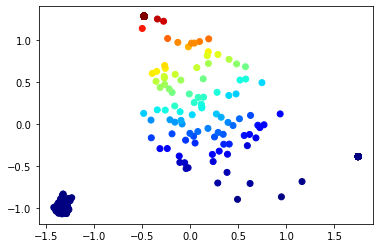

In [62]:
# N = 100
ss, _, pca_faces = sample_single_face(resample=True, resample_N=100, mode = 'uniform')
colors = np.hstack(((np.ones(200), np.zeros(400), ss[:, 0])))
plt.scatter(*(pca_faces.T), c = (colors), cmap='jet')

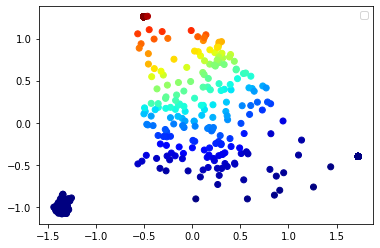

In [40]:
_, pca_faces = sample_single_face()
colors = np.hstack(((np.ones(200), np.zeros(400), simplex_sample[:, 0])))

plt.scatter(*(pca_faces.T), c = (colors), cmap='jet')

0.49990190739636836
(300, 3)


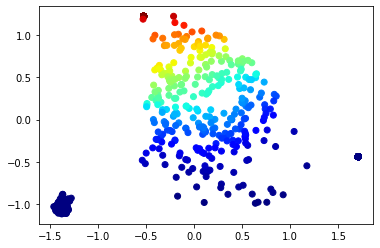

In [63]:
# N = 100
ss, _, pca_faces = sample_single_face(resample=True, resample_N=300, mode = 'uniform')
colors = np.hstack(((np.ones(200), np.zeros(400), ss[:, 0])))
plt.scatter(*(pca_faces.T), c = (colors), cmap='jet')

0.49989648046918383
(1000, 3)


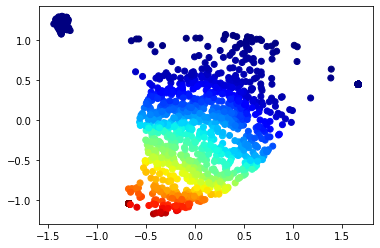

In [64]:
# N = 100
ss, _, pca_faces = sample_single_face(resample=True, resample_N=1000, mode = 'uniform')
colors = np.hstack(((np.ones(200), np.zeros(400), ss[:, 0])))
plt.scatter(*(pca_faces.T), c = (colors), cmap='jet')

### Uniform sampling

- Red corresponds to Ni
- Blue corresponds to no Ni

![image-4.png](attachment:image-4.png "N = 100")
![image-3.png](attachment:image-3.png "N = 200")
![image-2.png](attachment:image-2.png "N = 300")
![image.png](attachment:image.png "N = 1000")
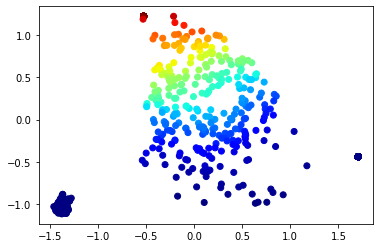
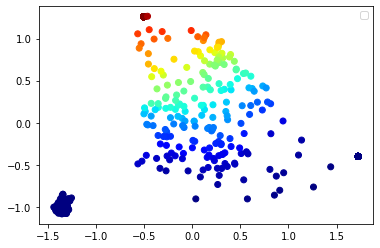
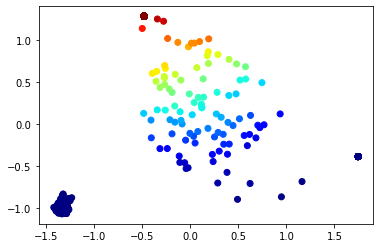
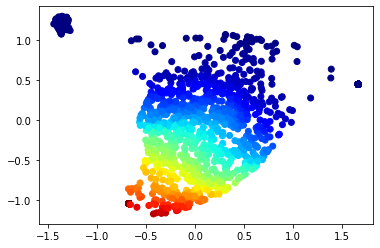

### Biased simplex sampling

Train on 200 points per face

0.501280105213001
(200, 3)
scale type: shift
q jitter: None
peak height variation True


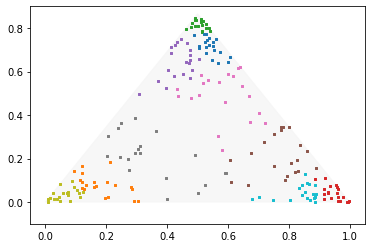

In [65]:
simplex_sample = get_simplex_sample(200, mode = 'biased')
faces = get_faces(simplex_sample)
CoNiSn_x_shift_faces, CoNiSn_y_shift_faces = sample_transition(np.vstack(points + edges + faces), n_classes = 140, per_class = 120)

In [66]:
prefix="CoNiSn_shift_faces_500epoch_biased"
xdu.write_train_test("data/{}/".format(prefix), CoNiSn_x_shift_faces, CoNiSn_y_shift_faces,
                 CoNiSn_x_shift_faces, CoNiSn_y_shift_faces // 10)
%run ../../siamese-net-and-friends/train.py siamese-constrastive_1d XRD --train_path data/$prefix/train/ --test_path data/$prefix/test/\
    --name $prefix \
    --n_classes 140 --epochs 500

  0%|          | 0/262500 [00:00<?, ?it/s, epoch=0, train_loss=0, val_loss=-1]

4
./data/XRD


100%|██████████| 262500/262500 [55:07<00:00, 79.36it/s, epoch=499, train_loss=0.0109, val_loss=0.0105]  


Saving artifacts to ./tmp/siamese-constrastive_1d-XRD-CoNiSn_shift_faces_500epoch_biased-*


<Figure size 432x288 with 0 Axes>

0.5015644972512864
(100, 3)


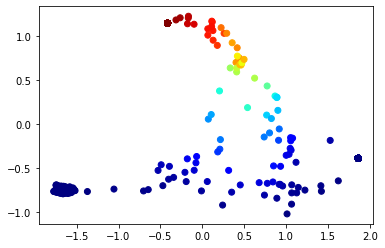

In [67]:
# N = 100
ss, _, pca_faces = sample_single_face(resample=True, resample_N=100, mode = 'biased')
colors = np.hstack(((np.ones(200), np.zeros(400), ss[:, 0])))
plt.scatter(*(pca_faces.T), c = (colors), cmap='jet')

0.5014196408940976
(200, 3)


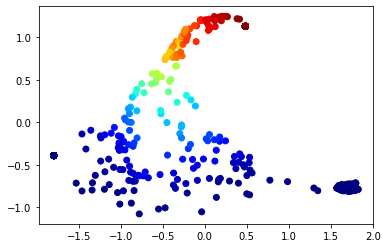

In [68]:
# N = 100
ss, _, pca_faces = sample_single_face(resample=True, resample_N=200, mode = 'biased')
colors = np.hstack(((np.ones(200), np.zeros(400), ss[:, 0])))
plt.scatter(*(pca_faces.T), c = (colors), cmap='jet')

0.5015535484515797
(300, 3)


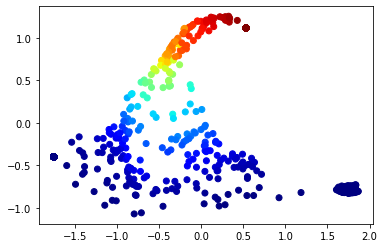

In [69]:
# N = 100
ss, _, pca_faces = sample_single_face(resample=True, resample_N=300, mode = 'biased')
colors = np.hstack(((np.ones(200), np.zeros(400), ss[:, 0])))
plt.scatter(*(pca_faces.T), c = (colors), cmap='jet')

0.5013747726496366
(1000, 3)


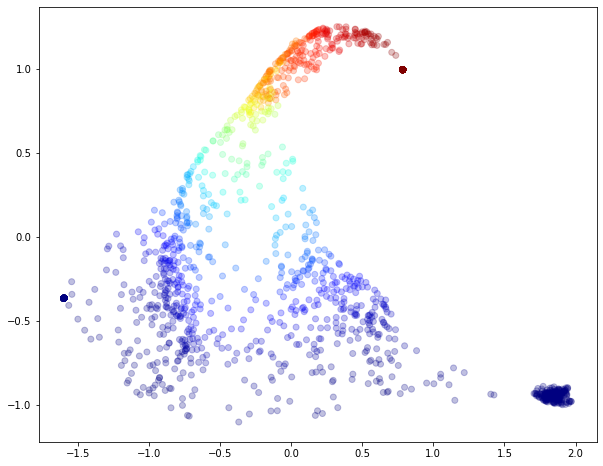

In [83]:
# N = 1000
ss, _, pca_faces = sample_single_face(resample=True, resample_N=1000, mode = 'biased')
colors = np.hstack(((np.ones(200), np.zeros(400), ss[:, 0])))
plt.scatter(*(pca_faces.T), c = (colors), cmap='jet', alpha = .25)

0.5012389315609863
(1000, 3)


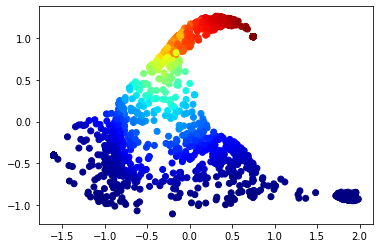

In [71]:
# N = 1000
ss, _, pca_faces = sample_single_face(resample=True, resample_N=1000, mode = 'biased')
colors = np.hstack(((np.ones(200), np.zeros(400), ss[:, 0])))
plt.scatter(*(pca_faces.T), c = (colors), cmap='jet')

### Biased sampling

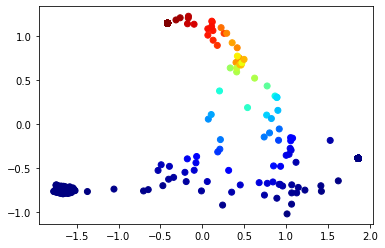
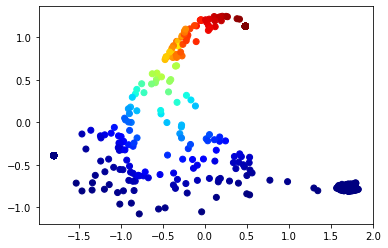
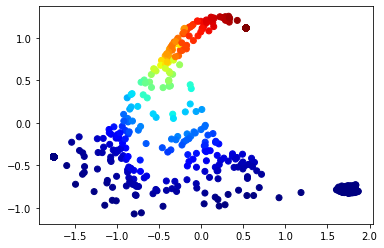
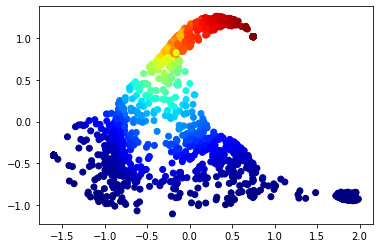

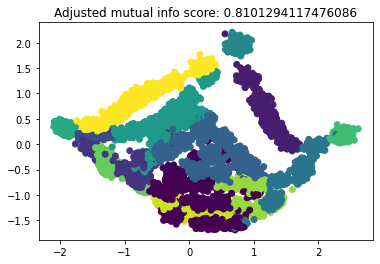

In [64]:
Xpca_tetra, y_tetra, ypred_tetra = embedding_gmm(14)

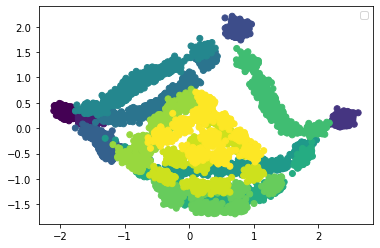

In [65]:
plt.scatter(*(Xpca_tetra.T), c = y_tetra)
plt.legend()

## Scatter plot of three vertices (Co, Ni, CoNi) and one face (three-phase combination of the vertices):

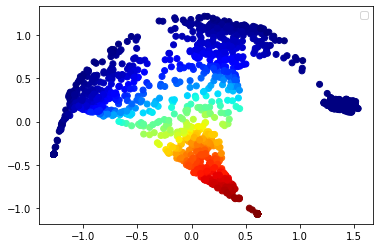

In [247]:
# N = 12000
# plt.scatter(*(Xpca_tetra[:N].T), c = y_tetra[:N])

# plt.scatter(*(pca_faces.T), c = (y_faces))
plt.scatter(*(pca_faces.T), c = (colors), cmap='jet')

plt.legend()

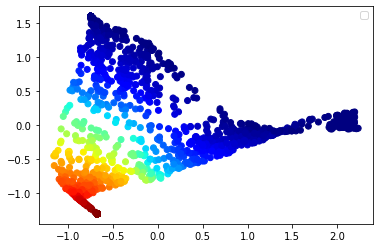

In [261]:
# N = 12000
# plt.scatter(*(Xpca_tetra[:N].T), c = y_tetra[:N])

# plt.scatter(*(pca_faces.T), c = (y_faces))
plt.scatter(*(pca_faces.T), c = (colors), cmap='jet')

plt.legend()

In [76]:
tmp = list(enumerate(original_test_loader))[0]

### Effect of noise on latent space representation:

In [51]:
pattern = X[0]
m0, m1, m2, m3, m4 = [xdu.mutate_pattern(pattern, 0, xdu.q_grid, scale_type = 'shift', peak_height = False, noise_scale = noise)
             for noise in [0.1, 1, 2, 4, 8]]

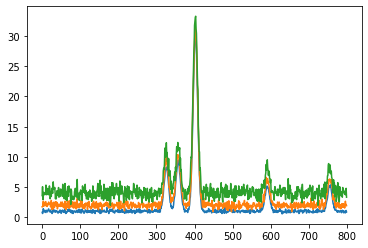

In [53]:
plt.plot(m1)
plt.plot(m2)
plt.plot(m3)
plt.plot(m4)

In [297]:
# #def add_shot_noise(sig_relative):
# def poisson_additive(pattern, noise_scale = 1, poisson_lam = 30):
#     """
#     Add nonnegative noise to the pattern
#     """
#     return pattern + np.random.poisson(lam = poisson_lam, size = len(pattern)) / (poisson_lam / (noise_scale * pattern.mean()))

In [61]:
from importlib import reload
reload(xdu)

<module 'xrdc.xrdutils' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/xrdutils.py'>

In [87]:
CoNi_x_shift_p1, CoNi_y_shift_p1 = sample_transition(np.vstack((Co_to_CoNi_shift, CoNi_to_CoNi_shift, CoNi_to_Ni_shift)),
                                               n_classes = 30, per_class = 200, noise_scale=1, peak_height = False)

xdu.write_train_test("data/CoNi_shift_2_1/", CoNi_x_shift_p1, CoNi_y_shift_p1, CoNi_x_shift_p1, CoNi_y_shift_p1 // 10)

prefix="CoNi_shift_2_1"
%run ../../siamese-net-and-friends/train.py siamese-constrastive_1d XRD --train_path data/$prefix/train/ --test_path data/$prefix/test/\
    --name $prefix \
    --n_classes 30 --epochs 200

scale type: shift
q jitter: None


In [65]:
xdu.write_train_test("data/CoNi_shift_p1/", CoNi_x_shift_p1, CoNi_y_shift_p1, CoNi_x_shift_p1, CoNi_y_shift_p1 // 8)

In [70]:
prefix="CoNi_shift_p1"
%run ../../siamese-net-and-friends/train.py siamese-constrastive_1d XRD --train_path data/$prefix/train/ --test_path data/$prefix/test/\
    --name $prefix \
    --n_classes 200 --epochs 200

  0%|          | 0/6400 [00:00<?, ?it/s, epoch=0, train_loss=0, val_loss=-1]

4
./data/XRD


100%|██████████| 6400/6400 [02:51<00:00, 37.34it/s, epoch=199, train_loss=0.0284, val_loss=0.0286]


Saving artifacts to ./tmp/siamese-constrastive_1d-XRD-CoNi_shift_p1-*


<Figure size 432x288 with 0 Axes>

In [96]:
def do_scatter(N):
    X, y = utils.get_embedding(net, original_test_loader)
    Xpca, ypred = xdu.gcluster(X, N = N)
    plt.scatter(*(Xpca.T), c = y)

In [104]:
prefix="CoNi_shift_p0"
ns = .1

CoNi_x_shift_p, CoNi_y_shift_p = sample_transition(np.vstack((Co_to_CoNi_shift, CoNi_to_CoNi_shift, CoNi_to_Ni_shift)),
                                               n_classes = 30, per_class = 200, noise_scale=ns, peak_height = False)

xdu.write_train_test("data/{}/".format(prefix), CoNi_x_shift_p, CoNi_y_shift_p, CoNi_x_shift_p, CoNi_y_shift_p // 10)

%run ../../siamese-net-and-friends/train.py siamese-constrastive_1d XRD --train_path data/$prefix/train/ --test_path data/$prefix/test/\
    --name $prefix \
    --n_classes 30 --epochs 200

scale type: shift
q jitter: None


  0%|          | 0/37600 [00:00<?, ?it/s, epoch=0, train_loss=0, val_loss=-1]

4
./data/XRD


100%|██████████| 37600/37600 [10:07<00:00, 61.92it/s, epoch=199, train_loss=0.0239, val_loss=0.0227] 


Saving artifacts to ./tmp/siamese-constrastive_1d-XRD-CoNi_shift_p0-*


<Figure size 432x288 with 0 Axes>

### Noise param == .1:

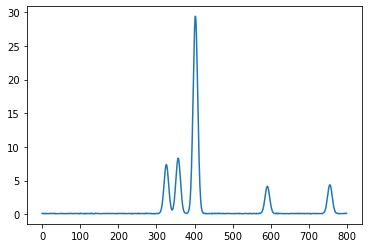

In [106]:
plt.plot(m0)

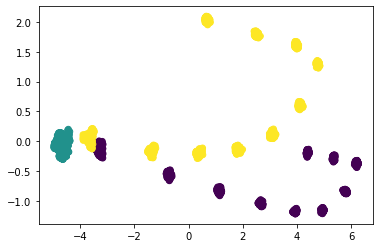

In [105]:
do_scatter(3)

### Noise param == 1:

In [103]:
torch.save(original_test_loader, 'fooar')

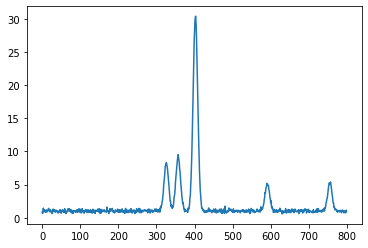

In [101]:
plt.plot(m1)

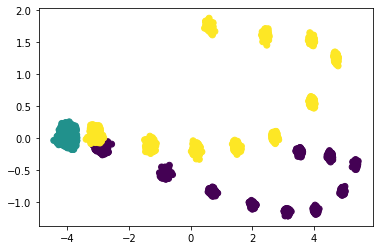

In [97]:
do_scatter(3)

In [98]:
prefix="CoNi_shift_p8"
ns = 8

CoNi_x_shift_p, CoNi_y_shift_p = sample_transition(np.vstack((Co_to_CoNi_shift, CoNi_to_CoNi_shift, CoNi_to_Ni_shift)),
                                               n_classes = 30, per_class = 200, noise_scale=ns, peak_height = False)

xdu.write_train_test("data/{}/".format(prefix), CoNi_x_shift_p, CoNi_y_shift_p, CoNi_x_shift_p, CoNi_y_shift_p // 10)

%run ../../siamese-net-and-friends/train.py siamese-constrastive_1d XRD --train_path data/$prefix/train/ --test_path data/$prefix/test/\
    --name $prefix \
    --n_classes 30 --epochs 200

scale type: shift
q jitter: None


  0%|          | 0/37600 [00:00<?, ?it/s, epoch=0, train_loss=0, val_loss=-1]

4
./data/XRD


100%|██████████| 37600/37600 [09:27<00:00, 66.29it/s, epoch=199, train_loss=0.0317, val_loss=0.0306] 


Saving artifacts to ./tmp/siamese-constrastive_1d-XRD-CoNi_shift_p8-*


<Figure size 432x288 with 0 Axes>

### Noise param == 8

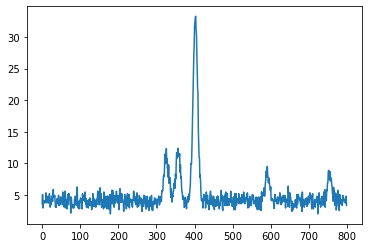

In [100]:
plt.plot(m3)

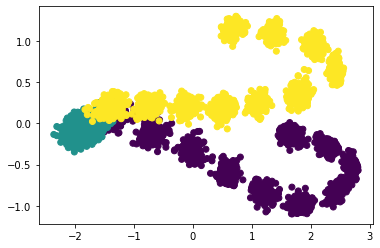

In [99]:
do_scatter(3)

### Noise param == very small:
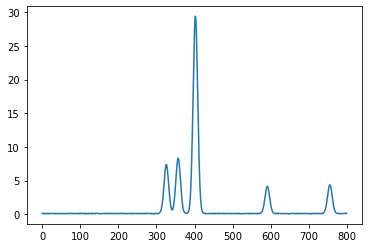
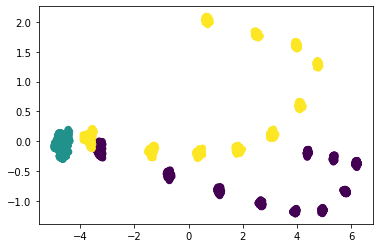

### Noise param == 1: 
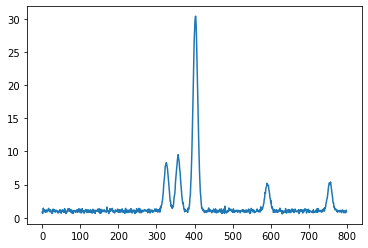
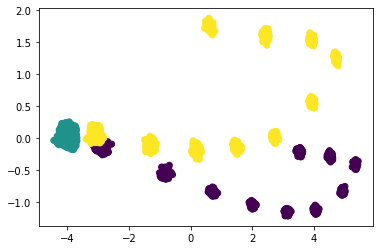

### Noise param == 8:
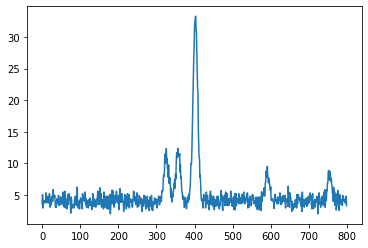
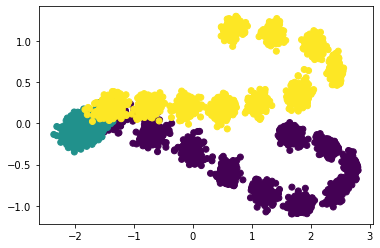

In [82]:
CoNiSn_x_shift_faces[:, None, :].shape

(16800, 1, 150)

In [ ]:
utils.get_embedding(net, original_test_loader)

In [301]:
from xrdc.utils.utils import utils as outils

<IPython.core.display.Javascript object>


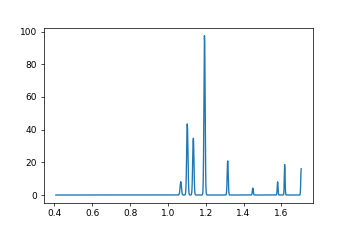

In [363]:
x = q_grid
y = iia

from scipy.interpolate import interp1d
def logtransform(x, y):
    logx = np.log(x)
    interp = interp1d(logx, y)

    logx_new = np.linspace(logx.min(), logx.max(), len(logx))
    return logx_new, interp(logx_new)

plt.plot(*logtransform(x, y))

In [353]:
%matplotlib notebook

In [364]:
xl1, il1 = logtransform(x, mutate_pattern(y, .95, x, peak_height=False))

In [365]:
xl2, il2 = logtransform(x, mutate_pattern(y, 1, x, peak_height=False))

<IPython.core.display.Javascript object>


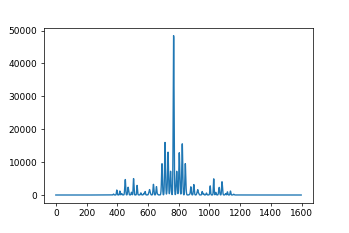

([<matplotlib.lines.Line2D at 0x7fc61267be50>],
 1.6572125458766052,
 1.704293560424763,
 -0.05129329438755058,
 0.048704497808439995)

In [392]:
plt.plot(np.correlate(il1, il2, mode = 'full')), xl1[770], xl1[799], np.log(.95), 30 * (xl1[1] - xl1[0])

In [ ]:
plt.plot()

In [362]:
plt.plot(*logtransform(x, mutate_pattern(y, .95, x, peak_height=False)))
plt.plot(*logtransform(x, mutate_pattern(y, 1., x, peak_height=False)))

<IPython.core.display.Javascript object>

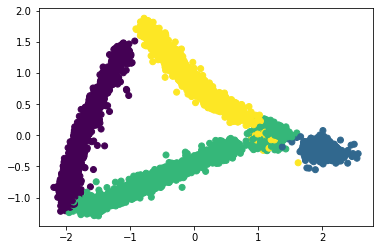

In [315]:
X_emb, y = utils.get_embedding(net, original_test_loader)

Xpca, ypred = gcluster(X_emb, N = 4)
plt.scatter(*(Xpca.T), c = ypred)

In [306]:
plt.scatter?

### Co-Ni synthetic dataset clustering

* Augmented datset with 20 dummy classes
* 4-dimensional latent space
* GMM recovers clusters much better than K means due to non-spherical shape of the clusters
* 4 dimensional latent space better than 2 for identifying clusters

In [ ]:
plt.scatter(*(Xpca.T), c = ypred)

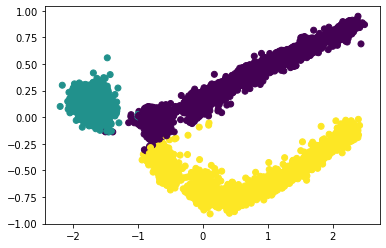

In [105]:
write_train_test("data/CoNi_shift_small/", CoNi_x_shift, CoNi_y_shift, CoNi_x_shift,\
                 (CoNi_y_shift // 67))

In [115]:
CoNi_x_shift_group, CoNi_y_shift_group = group_patterns(Co_to_CoNi_shift, CoNi_to_CoNi_shift, CoNi_to_Ni_shift, n_classes = 200)

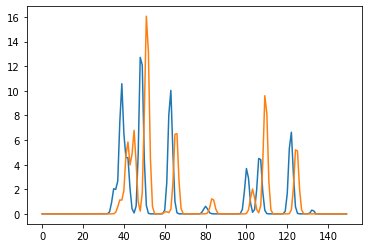

In [119]:
plt.plot(CoNi_x_shift_group[0])
plt.plot(CoNi_x_shift_group[2])

In [121]:
write_train_test("data/CoNi_shift_grouped/", CoNi_x_shift_group, CoNi_y_shift_group, CoNi_x_shift_group,\
                 (CoNi_y_shift_group // 67))

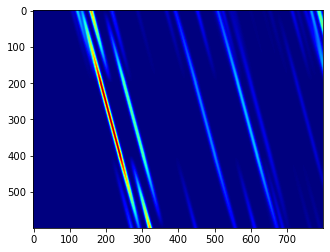

In [202]:
X_shift = np.vstack((Co_to_CoNi_shift, CoNi_to_CoNi_shift, CoNi_to_Ni_shift))
plt.imshow(X_shift, cmap = 'jet')

In [212]:
CoNi_members_shift, CoNi_y_shift = agg(X_shift)

In [214]:
CoNi_x_shift, CoNi_y_shift = sims.mk_simdata(CoNi_members_shift, 500, 20, scale_type = 'shift')

utils.write_train_test("data/CoNi_shift/", CoNi_x_shift, CoNi_y_shift, CoNi_x_shift, CoNi_y_shift)

scale type: shift


In [241]:
assert np.where(np.isnan(CoNi_x) == True)

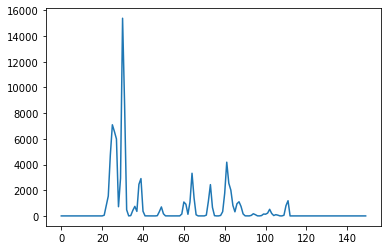

In [269]:
plt.plot(CoNi_x[15])

In [ ]:
# def condense(arr, newsize):
#     extra = newsize - (len(arr) % newsize)
#     arr = np.hstack((arr, np.zeros(extra)))
#     return arr.reshape(newsize, -1).sum(axis = 1)

def view_ds(arr):
    """
    2d heatmap of dataset, rows sorted by first moment in q
    """
    plt.imshow(arr[np.argsort(
    (arr * condense(q_grid, 150, norm = False)).mean(axis = 1)
)].reshape(200, 50, 150).sum(axis = 1))

In [452]:
prefix="CoNi_shift_extended"
%run ../../siamese-net-and-friends/train.py siamese-constrastive_1d XRD --train_path data/$prefix/train/ --test_path data/$prefix/test/\
    --name $prefix \
    --n_classes 200 --epochs 1600

4
./data/XRD


100%|██████████| 500800/500800 [1:55:25<00:00, 72.31it/s, epoch=1599, train_loss=0.0134, val_loss=0.0133]  


Saving artifacts to ./tmp/siamese-constrastive_1d-XRD-CoNi_shift_extended-*


<Figure size 432x288 with 0 Axes>

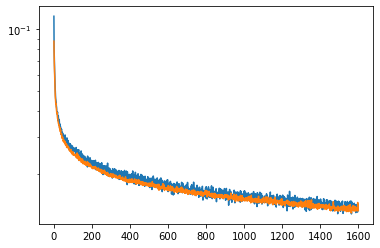

In [453]:
import matplotlib.pyplot as plt
plt.semilogy()
plt.plot(stats_collector['train_loss'])
plt.plot(stats_collector['val_loss'])

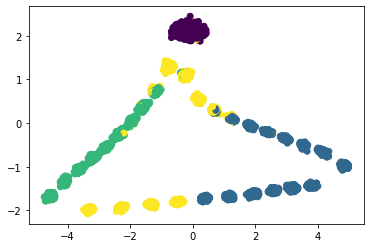

In [454]:
X_emb, y = utils.get_embedding(net, original_test_loader)

Xpca, ypred = gcluster(X_emb, N = 4)
plt.scatter(*(Xpca.T), c = ypred)

Train the model without augmentation (i.e., only using neighborhood information):

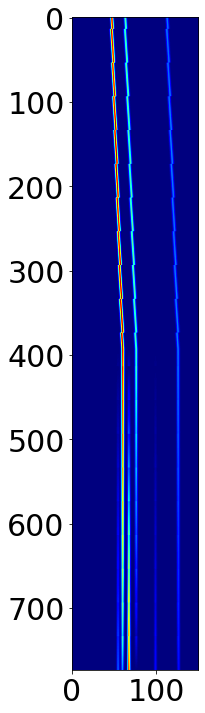

In [340]:
raw_train = np.vstack((Co_to_CoNi_shift, CoNi_to_CoNi_shift, CoNi_to_Ni_shift))

import slide_tricks as st

sliding_x = st.sliding_window_view(raw_train, (40, 800)).squeeze(axis = 1)[::20]
sliding_y = np.arange(sliding_x.shape[0] * sliding_x.shape[1]) // sliding_x.shape[1]

sliding_X, sliding_Y = xdu.standardize_input(sliding_x.reshape((-1, 800)), sliding_y)

plt.imshow(sliding_X[1160 // 3: ], cmap = 'jet')

In [342]:
sliding_Y // 10

array([[0],
       [0],
       [0],
       ...,
       [2],
       [2],
       [2]])

In [344]:
prefix = 'CoNi_sliding_40_20'
xdu.write_train_test("data/{}/".format(prefix), sliding_X, sliding_Y, sliding_X, sliding_Y // 10)

In [345]:
%run ../../siamese-net-and-friends/train.py siamese-constrastive_1d XRD --train_path data/$prefix/train/ --test_path data/$prefix/test/\
    --name $prefix \
    --n_classes 29 --epochs 200

  0%|          | 0/7400 [00:00<?, ?it/s, epoch=0, train_loss=0, val_loss=-1]

4
./data/XRD


100%|██████████| 7400/7400 [02:29<00:00, 49.49it/s, epoch=199, train_loss=0.0262, val_loss=0.0273]


Saving artifacts to ./tmp/siamese-constrastive_1d-XRD-CoNi_sliding_40_20-*


<Figure size 720x864 with 0 Axes>

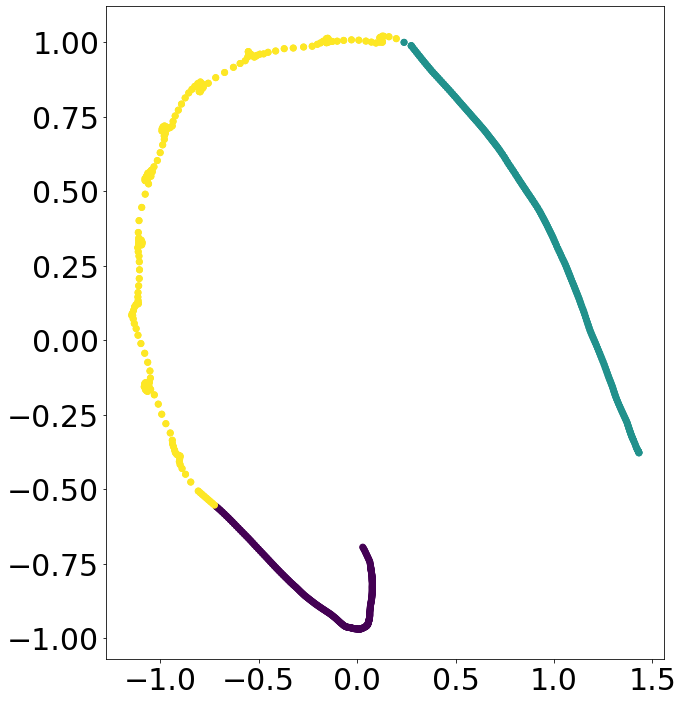

In [348]:
X, Y = utils.get_embedding(net, original_test_loader)

Xpca, ypred = xdu.gcluster(X, N = 3)
plt.scatter(*(Xpca.T), c = ypred)

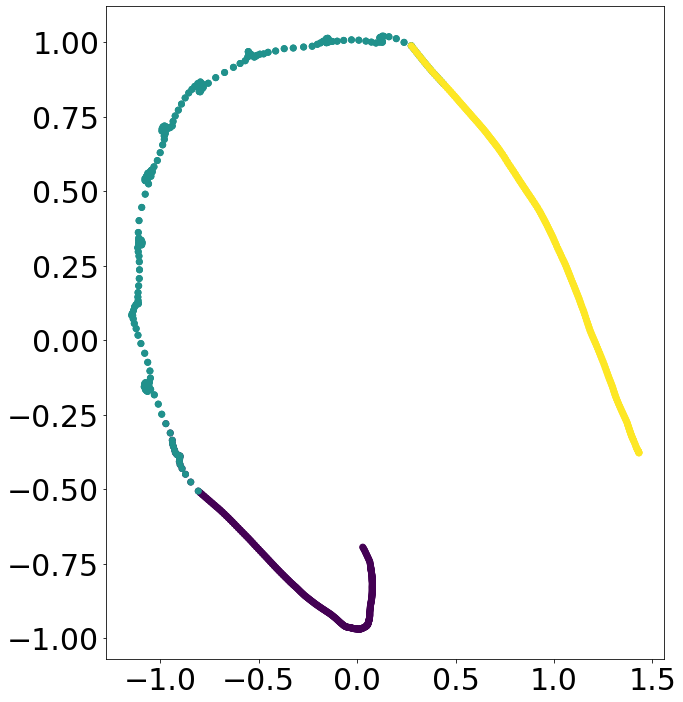

In [349]:
plt.scatter(*(Xpca.T), c = Y)